# Dielectric Properties of Natural Media

In this notebook we want to look at how different surfaces like water, forest grasland and cities give us different backscatter.

We are going to load backscatering data from Sentinel 1 and we will use the Corine Landcoverdata to get a classification of different surfaces.

TODO:
include time series - how much data changes over time or is affected by certain weather

## Import packages

In [1]:
# tidy up!
import json

import os
import xarray as xr
import rioxarray
import rasterio
import numpy as np
from rasterio.crs import CRS
import dask.array as da
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import folium
import matplotlib.patches as patches
from datetime import datetime
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from pyproj import Transformer


## Load Sentinel 1 data

Load Metadata to get some information on the data. Using '.tags()' we can extract a lot of useful information like the scale_factor.

As we can see frome here the data was captured 8 images between the 5th August 2023 and the 28th October 2023. The image contains Gamma VV values.

Now we can load the data and and apply preprocessing. From the Metaddata we could extract a scalingfactor of 100 which we now need to apply.

We get a xarray.DataSet and convert it to an xarray.DataArray because we only have one variable, the VV backscatter.

We have 8 timestemps. For performance reasons we will fous on only on one time becasue the data does not change to much over time.

We downsample already in the preprocessing because we do not need all the resolution because we are working with the corine data map and the resolution there is 100 by 100 meters. When we downsample x and y coordinates by 10 we get pixles of size 100 by 100meters which fits perfectly to the 

(insert image of downscaled, normal and corine landcover)

In [2]:
data_path = Path('~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler').expanduser() # SAT-1 data is inside the saocom_gamma folder but this could change
tif_files = glob(f"{data_path}/*.tif")

from pprint import pprint

def _preprocess(x):
    file = x.encoding['source']

    print(f"{os.path.basename(file)}:")
    print(json.dumps(rasterio.open(file).tags(), indent=4))

    scale_factor = pd.to_numeric(
        rasterio.open(x.encoding["source"]).tags().get('scale_factor')
    )
    x = x / scale_factor
    
    time_value = pd.to_datetime(              # is there a better way to get the date?
        rasterio.open(x.encoding["source"]).tags().get('time_begin')
    )
    x = x.assign_coords(time=time_value).expand_dims("time")

    return x.rename(
        {"band_data": "sig0"}
    ).squeeze("band").drop_vars("band")


sig0_ds_large = xr.open_mfdataset(
    '~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler/*.tif',
    engine="rasterio",
    combine='nested',
    concat_dim="time",
    preprocess=_preprocess
)

sig0_ds_large = sig0_ds_large[list(sig0_ds_large.data_vars.keys())[0]]
sig0_ds_large

D20230805_165122--_GMR------_S1AIWGRDH1VVA_146_A0105_EU010M_E052N015T1.tif:
{
    "abs_orbit_number": "049743",
    "band_1": "Gamma0_VV",
    "border_noise_removed": "True",
    "creator": "TUWGEO",
    "distanceuom": "m",
    "distancevalue": "10",
    "equi7_tile": "EU010M_E052N015T1",
    "ext_dem": "/eodc/private/tuwgeo/users/acube/data/input/acube_dem_eh.tif",
    "grid": "Equi7 Grid",
    "gtc_applied": "True",
    "log_file": "tasklist_2_A01_gmr_jobfile_A0105_log_20231201_034630.xml",
    "orbit_aux_file": "POE",
    "parent_data_file": "S1A_IW_GRDH_1SDV_20230805T165122_20230805T165147_049743_05FB3C_64DB.zip",
    "polarisation": "VV",
    "precise_orbit_applied": "True",
    "processing_date": "2023-12-01 03:46:31",
    "processing_software": "SGRT",
    "processing_software_version": "A0105-2.4.9.post.dev6.pre",
    "rel_orbit_number": "146",
    "rtf_applied": "True",
    "sat_product_id": "S1AIWGRDH1VVA",
    "scale_factor": "100.0",
    "thermal_noise_removed": "True",
   

<xarray.DataArray 'sig0' (time: 8, y: 10000, x: 10000)> Size: 6GB
dask.array<concatenate, shape=(8, 10000, 10000), dtype=float64, chunksize=(1, 1, 10000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 80kB 5.2e+06 5.2e+06 5.2e+06 ... 5.3e+06 5.3e+06
  * y            (y) float64 80kB 1.6e+06 1.6e+06 1.6e+06 ... 1.5e+06 1.5e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 64B 2023-08-05T16:51:22 ... 2023-10-28...

In [3]:
bounding_box = {
    'x_min': 5_280_000.0,
    'x_max': 5_295_000.0,
    'y_min': 1_560_000.0,
    'y_max': 1_570_000.0
}

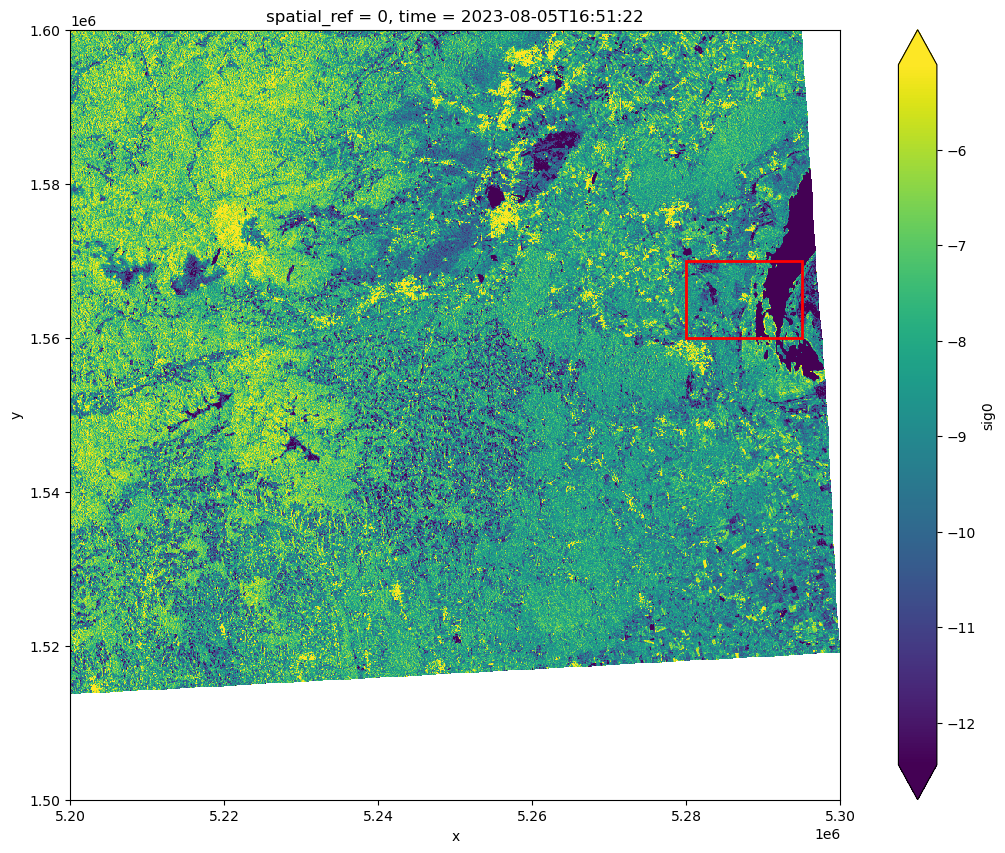

In [4]:
img = sig0_ds_large.isel(time=0) .coarsen(x=10, y=10, boundary='pad').mean()

fig, ax = plt.subplots(figsize=(15, 10))

img.plot(ax=ax, robust=True)

rect = patches.Rectangle(
    (bounding_box['x_min'], bounding_box['y_min']),
    bounding_box['x_max'] - bounding_box['x_min'],
    bounding_box['y_max'] - bounding_box['y_min'],
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)
ax.set_aspect('equal')

plt.show()

In [5]:
sig0_ds = sig0_ds_large.sel(
    x=slice(bounding_box['x_min'], bounding_box['x_max']),
    y=slice(bounding_box['y_max'], bounding_box['y_min'])
)
sig0_ds

<xarray.DataArray 'sig0' (time: 8, y: 1000, x: 1500)> Size: 96MB
dask.array<getitem, shape=(8, 1000, 1500), dtype=float64, chunksize=(1, 1, 1500), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 12kB 5.28e+06 5.28e+06 ... 5.295e+06 5.295e+06
  * y            (y) float64 8kB 1.57e+06 1.57e+06 ... 1.56e+06 1.56e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 64B 2023-08-05T16:51:22 ... 2023-10-28...

To get an idea of the region we are looking at we want to display it. Using 'rubust=True' will use the 2nd and 98th percentiles of the data to compute the color limits. 

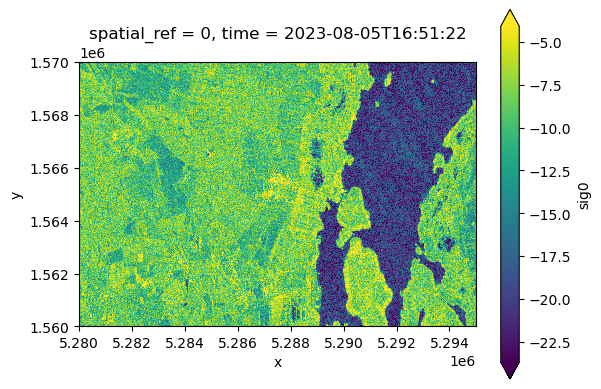

In [6]:
sig0_ds.isel(time=0).plot(robust=True).axes.set_aspect('equal')

## Load Corine Landcover data

We load the Corine Land Cover data which classifies the landcover of europa in 44 different areas.

We want to work with the Equi7 grid because it preserves geometric accuracy and minimises data oversampling over surfaces. So we need to convert the Corine Land Cover map to this coordinate system.

### Loading data

In [7]:
corine_path = Path('~/shared/datasets/rs/datapool/mrs/Corine_Land_Cover_2018.tif').expanduser()

print(f"CRS :{rasterio.open(corine_path).meta['crs']}")

corine_ds_large = (
    xr.open_dataset(corine_path,engine="rasterio")
    .rename({"band_data": "land_cover"})["land_cover"]
    .squeeze()
)

corine_ds_large

CRS :PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]


<xarray.DataArray 'land_cover' (y: 46000, x: 65000)> Size: 12GB
[2990000000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 520kB 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 368kB 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int64 8B ...
Attributes:
    DataType:                Thematic
    AREA_OR_POINT:           Area
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  136.429646247598
    STATISTICS_MAXIMUM:      48
    STATISTICS_MEAN:         25.753373398066
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       11.680310194836

### Select area of interest

In [8]:
transformer = Transformer.from_crs("EPSG:27704", "EPSG:3035", always_xy=True)

bbox_27704 = sig0_ds_large.rio.transform_bounds(sig0_ds_large.rio.crs)
bbox_3035 = transformer.transform_bounds(*bbox_27704)

print(bbox_27704)
print(bbox_3035)

x_min, y_min, x_max, y_max = bbox_3035
corine_ds = corine_ds_large.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

(5200000.0, 1500000.0, 5300000.0, 1600000.0)
(4728101.713653255, 2679708.979351567, 4844562.869274702, 2796700.500845548)


### Alignment of the datasets (raster + pixles)

In [9]:
def print_details(ds, ds_name):
    print(f"{ds_name}:")
    print(f"CRS: {ds.rio.crs}")
    print(f"Bounds: {ds.rio.bounds()}")
    print(f"Pixel size: {ds.rio.resolution()}\n")

In [10]:
print_details(corine_ds, "corine_ds")
print_details(sig0_ds, "sig0_ds")

corine_ds:
CRS: PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]
Bounds: (4728100.0, 2679700.0, 4844600.0, 2796700.0)
Pixel size: (100.0, -100.0)

sig0_ds:
CRS: EPSG:27704
Bounds: (5280000.0, 1560000.0, 5295000.0, 1570000.0)
Pixel size: (10.0, -10.0)



Reprojecting does a whole lot for us

In [11]:
corine_ds = corine_ds.rio.reproject_match(sig0_ds)

print_details(corine_ds, "corine_ds")
print_details(sig0_ds, "sig0_ds")

corine_ds:
CRS: EPSG:27704
Bounds: (5280000.0, 1560000.0, 5295000.0, 1570000.0)
Pixel size: (10.0, -10.0)

sig0_ds:
CRS: EPSG:27704
Bounds: (5280000.0, 1560000.0, 5295000.0, 1570000.0)
Pixel size: (10.0, -10.0)



### Colormapping and Encoding

The color mapping is stored in a json file under assets. The encoding can be found here: https://collections.sentinel-hub.com/corine-land-cover/readme.html 

In [12]:
with open('../assets/06_color_mapping.json', 'r') as f:
    color_mapping_data = json.load(f)

color_mapping = {item['value']: item for item in color_mapping_data['land_cover']}

colors = [info['color'] for info in color_mapping.values()]
categories = [info['value'] for info in color_mapping.values()]

cmap = ListedColormap(colors)
norm = BoundaryNorm(categories + [max(categories) + 1], len(categories))

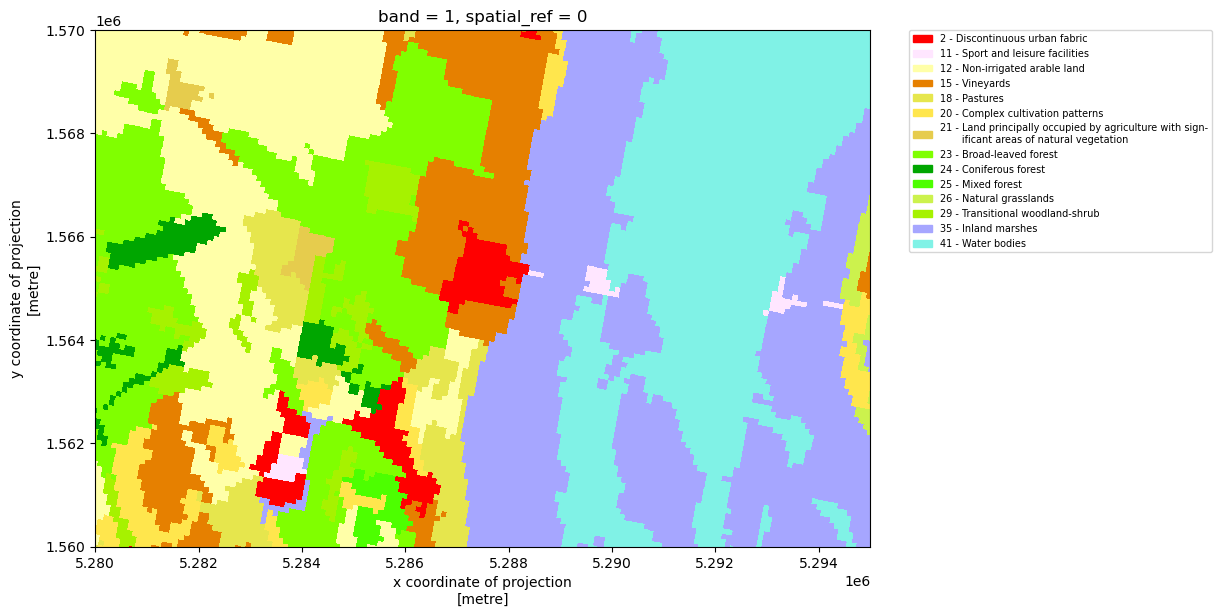

In [13]:
max_length = 50
indentation = ' ' * 7

unique_values = corine_ds.values[~np.isnan(corine_ds.values)].astype(int)

handles = [
    mpatches.Patch(color=info['color'], 
                   label=f'{info["value"]} - ' + 
                   (info["label"] if len(info["label"]) <= max_length 
                    else f'{info["label"][:max_length]}-\n{indentation}{info["label"][max_length:]}'))    
    for info in color_mapping.values() if info['value'] in unique_values
]

corine_ds.plot(figsize=(10, 10), cmap=cmap, norm=norm, add_colorbar=False).axes.set_aspect('equal')
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=7)
plt.show()

Now we can combine the datasets to one xarray dataset.

In [14]:
fs = xr.merge([sig0_ds,corine_ds]) .drop("band")
fs

/tmp/ipykernel_103258/1138911145.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  fs = xr.merge([sig0_ds,corine_ds]) .drop("band")


<xarray.Dataset> Size: 102MB
Dimensions:      (x: 1500, y: 1000, time: 8)
Coordinates:
  * x            (x) float64 12kB 5.28e+06 5.28e+06 ... 5.295e+06 5.295e+06
  * y            (y) float64 8kB 1.57e+06 1.57e+06 ... 1.56e+06 1.56e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 64B 2023-08-05T16:51:22 ... 2023-10-28...
Data variables:
    sig0         (time, y, x) float64 96MB dask.array<chunksize=(1, 1, 1500), meta=np.ndarray>
    land_cover   (y, x) float32 6MB 12.0 12.0 12.0 12.0 ... 35.0 35.0 35.0 35.0

### We create a Histogram for a specific landcover backscatter

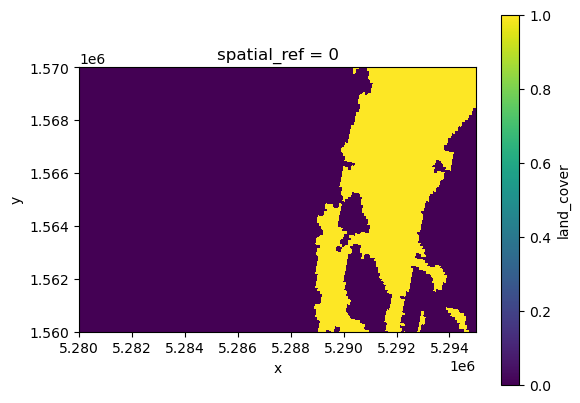

In [15]:
waterbodies_mask = (fs.land_cover == 41)

waterbodies_mask.plot().axes.set_aspect('equal')

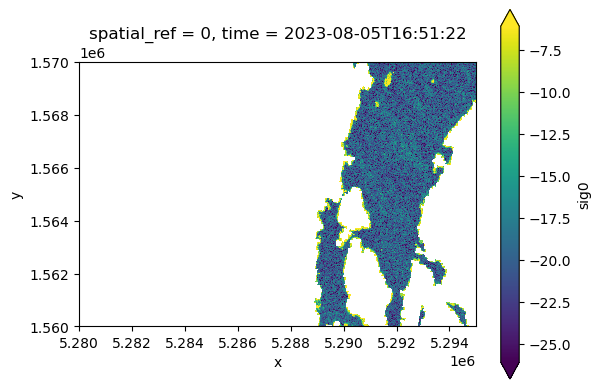

In [16]:
waterbodies_sig0 = fs.sig0.isel(time=0).where(waterbodies_mask)
waterbodies_sig0.plot(robust=True).axes.set_aspect('equal')

(array([5.0000e+00, 1.2000e+01, 3.8000e+01, 1.5200e+02, 4.7300e+02,
        1.2270e+03, 3.5930e+03, 1.0341e+04, 2.4635e+04, 4.4577e+04,
        6.7412e+04, 7.5855e+04, 5.4059e+04, 2.0049e+04, 5.0760e+03,
        2.8380e+03, 3.5350e+03, 4.7910e+03, 5.5180e+03, 4.6290e+03,
        2.5030e+03, 7.5700e+02, 1.6400e+02, 4.8000e+01, 3.3000e+01,
        1.6000e+01, 1.4000e+01, 1.7000e+01, 7.0000e+00, 9.0000e+00]),
 array([-3.79099998e+01, -3.62603340e+01, -3.46106682e+01, -3.29609985e+01,
        -3.13113327e+01, -2.96616669e+01, -2.80120010e+01, -2.63623352e+01,
        -2.47126675e+01, -2.30629997e+01, -2.14133339e+01, -1.97636681e+01,
        -1.81140022e+01, -1.64643345e+01, -1.48146687e+01, -1.31650009e+01,
        -1.15153351e+01, -9.86566925e+00, -8.21600151e+00, -6.56633568e+00,
        -4.91666794e+00, -3.26700211e+00, -1.61733627e+00,  3.23295593e-02,
         1.68199539e+00,  3.33166504e+00,  4.98133087e+00,  6.63099670e+00,
         8.28066254e+00,  9.93032837e+00,  1.15799999e+01]

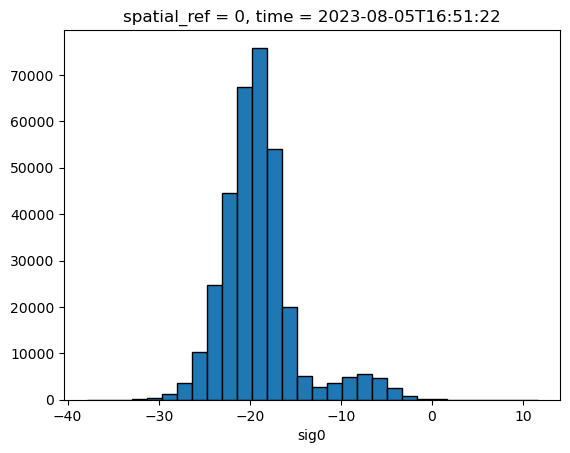

In [17]:
waterbodies_sig0.plot.hist(bins=30, edgecolor='black')

## Function for plotting

In [18]:
def calc_histogram(corine_ds, sig0_ds, feature_codes):

    all_backscatter_values = []
    mean_var = {}

    for code in feature_codes:
        if code not in color_mapping:
            print(f"Feature code {code} is not in the color mapping.")
            break
        
        mask = (corine_ds == code)

        backscatter_values = sig0_ds.where(mask, drop=True).values.flatten()
        backscatter_values = backscatter_values[~np.isnan(backscatter_values)]
        
        if len(backscatter_values) == 0:
            continue 
        
        all_backscatter_values.extend(backscatter_values)

        mean_value = np.mean(backscatter_values)
        variance_value = np.var(backscatter_values)

        mean_var[code] = {
            'mean': mean_value,
            'variance': variance_value
        }

    global_min = np.min(all_backscatter_values)
    global_max = np.max(all_backscatter_values)

    return global_min, global_max, mean_var

def plot_mask(ax, mask, feature_name):
    mask.plot(ax=ax)
    ax.set_title(f"{feature_name} Mask")
    ax.set_xlabel('x coordinate [meter]', labelpad=10)
    ax.set_ylabel('y coordinate [meter]', labelpad=10)
    ax.set_aspect('equal')

def plot_sig0(ax, sig0, feature_name):
    sig0.plot(ax=ax, robust=True)
    ax.set_title(f"{feature_name} sig0")
    ax.set_xlabel('x coordinate [meter]', labelpad=10)
    ax.set_ylabel('y coordinate [meter]', labelpad=10)
    ax.set_aspect('equal')
    cbar = ax.collections[0].colorbar
    cbar.set_label('Backscatter Value (dB)', labelpad=10)

def plot_histogram(ax, sig0, feature_name, x_min, x_max, mean_var):
    num_bins = int(np.ceil((x_max - x_min)))
    bin_edges = np.linspace(x_min, x_max, num_bins + 1)
    
    text_str = f"Mean: {mean_var['mean']:.2f}\nVariance: {mean_var['variance']:.2f}"

    sig0.plot.hist(ax=ax, bins=bin_edges, edgecolor='black')
    ax.set_title(f"{feature_name} sig0 Histogram")
    ax.set_xlabel('sig0 Value')
    ax.set_ylabel('Frequency')
    ax.set_xlim(x_min, x_max)
    ax.text(0.95, 0.95, text_str, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5))

def plot_classes(fs, feature_codes):

    corine_ds = fs.land_cover
    sig0_ds=fs.sig0 .mean(dim='time') .compute() # or use .isel(time=0) for one timevalue
    
    x_min, x_max, mean_var = calc_histogram(corine_ds, sig0_ds, feature_codes)

    n_rows = len(feature_codes)
    n_cols = 3
    
    axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))[1].flatten()

    for idx, code in enumerate(feature_codes):

        feature_info = color_mapping[code]
        feature_color = feature_info['color']
        feature_name = feature_info['label']
        
        # mask
        mask = (corine_ds == code).persist()      #.compute()    # a little bit faster with .compute()
        plot_mask(axes[idx * 3], mask, feature_name)

        # backscatter
        feature_backscatter = sig0_ds.where(mask)
        plot_sig0(axes[idx * 3 + 1], feature_backscatter, feature_name)

        # histogramm
        plot_histogram(axes[idx * 3 + 2], feature_backscatter, feature_name, x_min, x_max, mean_var[code])
        

    plt.tight_layout()
    plt.show()

The function can be used to plot the mask, the actuall backscatter and the histogram of the backscattering values of the corresponding landtype.
Be careful! Dont forget the frequency count on the y axis. They are different form each plot.

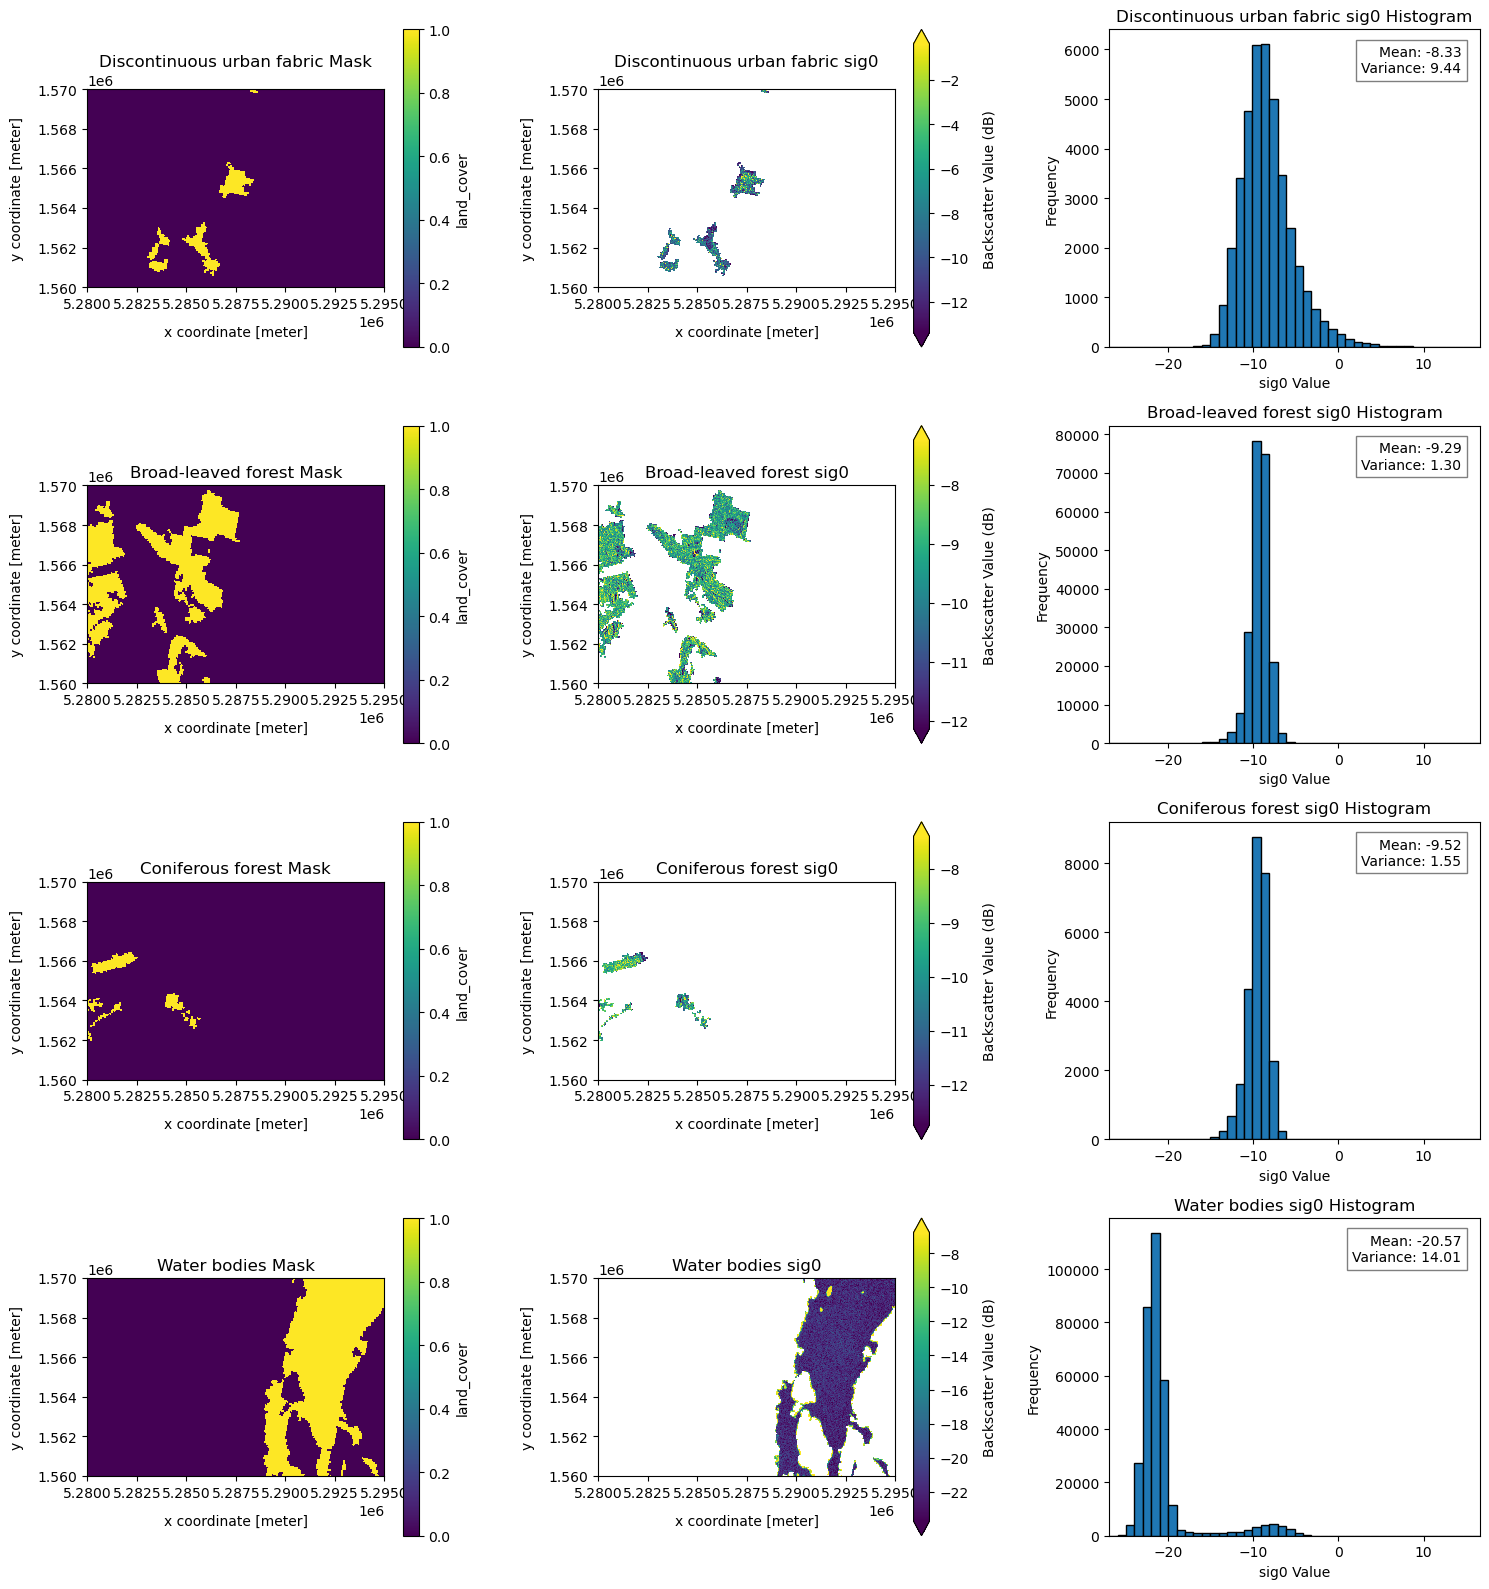

In [19]:
# specify the features that should be selected:
feature_codes = [2,23,24,41]

plot_classes(fs, feature_codes)

## Interactive Histograms over time using HoloViews

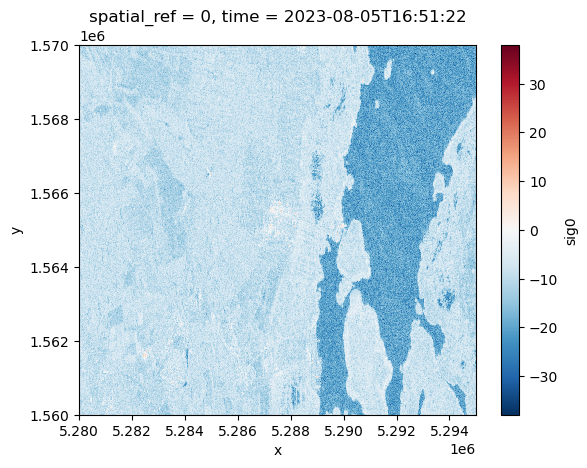

In [20]:
fs.sig0 .isel(time=0).plot()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
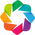

BokehModel(combine_events=True, render_bundle={'docs_json': {'0b6bd397-3f10-4305-94f5-40fd90aa35e0': {'version…

In [21]:
import holoviews as hv
import xarray as xr
hv.extension('bokeh')


# Create a Holoviews DynamicMap for time steps
time_dim = fs["time"]
sig0_da = fs["sig0"]

# Define a function to create a frame for each time step
def plot_backscatter(t):
    backscatter = sig0_da.sel(time=t)
    return hv.Image(backscatter, kdims=["x", "y"], vdims="sig0").opts(
        cmap="viridis", colorbar=True, title=f"Backscatter",
        width=500, height=500, tools=["hover"])

# Create a DynamicMap over the time dimension
dmap = hv.DynamicMap(plot_backscatter, kdims="time").redim.values(time=time_dim.values)

# Display the animation
dmap.opts(framewise=True)

In [22]:
import hvplot.xarray

In [23]:
fs=fs.compute()

In [24]:
fs.sig0 .hvplot.image(x="x", y="y", groupby="time", robust=True).opts(
        cmap="viridis", colorbar=True, title=f"Backscatter",
        tools=["hover"], aspect="equal")

BokehModel(combine_events=True, render_bundle={'docs_json': {'6bd79e98-087f-44b3-931a-f93fed45fb42': {'version…